# HighDimBiff Demo

You can run this 
* either on the cluster, by first converting this notebook to a script via ''jupyter nbconvert --to script run_mc.ipynb --template=nbconv.tpl'', then calling it from the command line via a slurm script with an extra argument specifying the amount of processes that can be allocated 
    * the conversion works on all notebook cells that have a tag 'export' (view -> cell toolbar -> tags)
* interactivly on your own computer with this notebook!


In [1]:
if isdefined(:cluster)
    using ClusterManagers
    N_tasks = parse(Int, ARGS[1])
    N_worker = N_tasks 
    addprocs(SlurmManager(N_worker))
    @everywhere include("/p/tmp/maxgelbr/code/HighBifLib.jl/HighBifLib.jl")
else
    #addprocs(1)
    @everywhere include("HighBifLib.jl")
    import Plots
end

@everywhere using LSODA
@everywhere using LightGraphs
using JLD2, FileIO, Clustering
@everywhere using DifferentialEquations
@everywhere using Distributions
@everywhere using HighBifLib  

# these imports invoke a lot of warnings when executed with multiple processes
# this seems to me to be more a bug of julia than an actual problem with this code
# imported on a single process there are no warnings

# Example 1: Order Parameter of Kuramoto Osc. 

We vary the initial conditions and the coupling strength. This is just to demonstrate how these kind of experiments are setup

**To-Do/Comment:** I am still very confused why and in which cases the @everywhere is needed. In this case the code doesn't work without any of the everywheres, but this goes against most of the explanations in the documentation.

In [4]:
@everywhere N = 5
@everywhere K = 0.5
@everywhere nd = Normal(0.5, 0.5) # distribution for eigenfrequencies # mean = 0.5Hz, std = 0.5Hz
@everywhere w_i_par = rand(nd,N) 

@everywhere net = erdos_renyi(N, 0.2)
@everywhere A = adjacency_matrix(net)


@everywhere ic = zeros(N)
@everywhere ic_dist = Normal(-pi,pi)
@everywhere ic_ranges = [()->rand(ic_dist)]
@everywhere N_ics = 10
#@everywhere ic_ranges = [-pi:pi/2:pi/2 for i=1:N]
@everywhere K_range = 0.0:1:10.
@everywhere pars = kuramoto_network_parameters(K, w_i_par, N, A)

# base problem
@everywhere rp = ODEProblem(kuramoto_network, ic, (0.,100.), pars)

# setup the MC problem with the helper function from the library
@everywhere (ic_coupling_problem, ic_par, N_mc) = setup_ic_par_mc_problem(rp, ic_ranges, N_ics, pars, (:K, K_range))

# for this first example we are only interested in the order parameter of the kuramoto model

# define the MC Problem
ko_mcp = MonteCarloProblem(rp, prob_func=ic_coupling_problem, output_func=eval_ode_run)
tail_frac = 0.9 # 
ko_emcp = EqMCProblem(ko_mcp, N_mc, tail_frac) 
ko_sol = solve(ko_emcp)




HighBifLib.myMCSol(MonteCarloSolution Solution of length 110 with uType:
NTuple{4,Array{Float64,1}}, 110, 400, 4)

In [5]:
D = distance_matrix(ko_sol, ic_par[:,2]);
k = 4
fdist = k_dist(D,k);

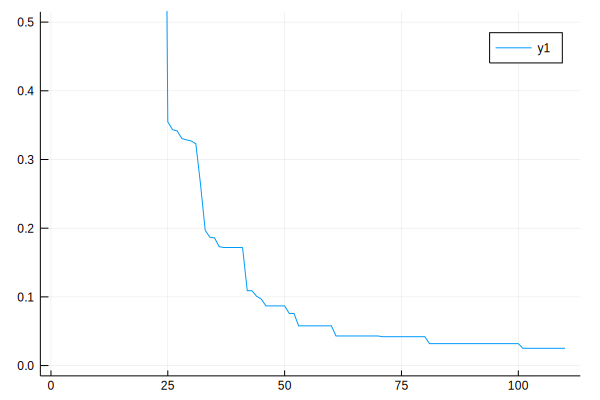

In [7]:
x = collect(1:ko_sol.N_mc)
Plots.plot(x[1:end],fdist[1:end],ylims=[0,0.5])

In [8]:
db_eps = 0.1
db_res = dbscan(D,db_eps,k)


Clustering.DbscanResult([28, 44, 45, 46, 47, 49, 51, 52, 53, 60], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  7, 8, 9, 2, 3, 4, 5, 1, 6, 10], [7, 8, 8, 8, 8, 8, 7, 6, 7, 7])

In [10]:
cluster_meas = cluster_measures(ko_sol,db_res);
cluster_n = cluster_n_noise(db_res);
cluster_members = cluster_membership(ic_par[:,end],db_res);

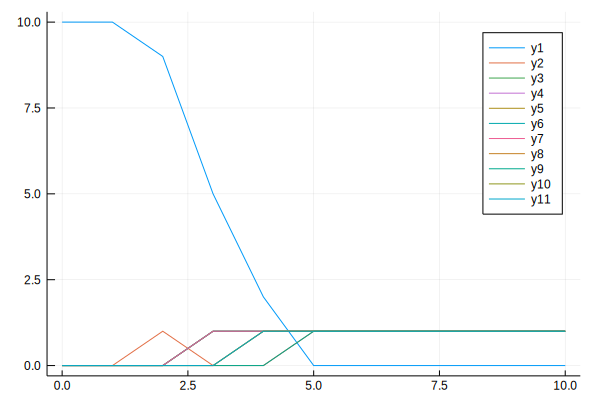

In [12]:
using Plots
plot(K_range,cluster_members)

# Example 2: Logistic Map

In [3]:
@everywhere r = 2.5:0.025:4
@everywhere pars = logistic_parameters(r[1])
@everywhere ic_ranges = [0.1:0.05:0.9]
@everywhere dp = DiscreteProblem(logistic, ic_ranges[1][1], (0.,500.), pars)
@everywhere (ic_r_prob, ic_par, N_mc) = setup_ic_par_mc_problem(dp, ic_ranges, pars, (:r, r))

log_mcp = MonteCarloProblem(dp, prob_func=ic_r_prob, output_func=eval_ode_run)
tail_frac = 0.8
log_emcp = EqMCProblem(log_mcp, N_mc, tail_frac)
log_sol = solve(log_emcp)

if isdefined(:cluster)
    @save "mc_log.jld2" log_sol
end 

In [ ]:
@load "mc_log.jld2" log_sol

In [12]:
D = distance_matrix(log_sol, ic_par[:,2]);
k = 4
fdist = k_dist(D,k);

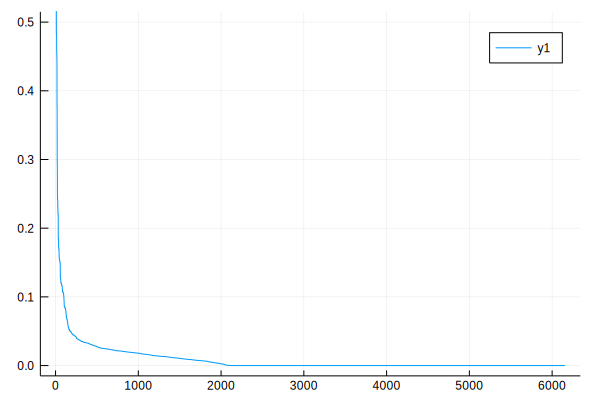

In [4]:
x = collect(1:log_sol.N_mc)
Plots.plot(x[1:end],fdist[1:end],ylims=[0,0.5])

In [13]:
db_eps = 0.05

0.05

In [14]:
db_res = dbscan(D,db_eps,k)


Clustering.DbscanResult([1, 290, 324, 341, 361, 375, 528, 545, 562, 579  …  732, 749, 798, 817, 835, 904, 919, 921, 941, 1027], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  26, 0, 0, 26, 22, 26, 0, 22, 0, 22], [291, 32, 17, 15, 7, 153, 17, 17, 17, 17  …  8, 51, 36, 18, 24, 80, 4, 10, 5, 4])

In [15]:
cluster_meas = cluster_measures(log_sol,db_res);
cluster_n = cluster_n_noise(db_res);
cluster_members = cluster_membership(ic_par[:,end],db_res);

27×4×1 Array{Float64,3}:
[:, :, 1] =
 0.0616421   0.0219648     0.794183     0.088606  
 0.176527    6.60242e-17   0.0          0.0       
 0.0203559   2.86767e-13   0.0          0.0213806 
 0.010883    1.08769e-8   -0.0129495    0.0128367 
 0.00964072  0.000158353   0.0272547    0.0142939 
 0.00449136  0.000355677   0.15321      0.00675024
 0.0971891   0.0180333    -0.0255206    0.147541  
 0.010698    0.00272711    0.567716     0.0163934 
 0.0106789   0.00283505    0.561424     0.0163934 
 0.0106602   0.00293713   -0.00283562   0.0163934 
 0.0106417   0.00303398    0.54674      0.0163934 
 0.0212292   0.00634024    1.14038      0.0327869 
 0.00558819  0.00178792    0.0472251    0.00863131
 ⋮                                                
 0.0106025   0.00348566    0.0162312    0.0156084 
 0.0106106   0.00352385    0.0424408    0.0154572 
 0.004997    0.0016815     0.00841164   0.00722015
 0.0319957   0.0107961     0.0189675    0.0449988 
 0.0230995   0.00720904   -0.00326238   0.029

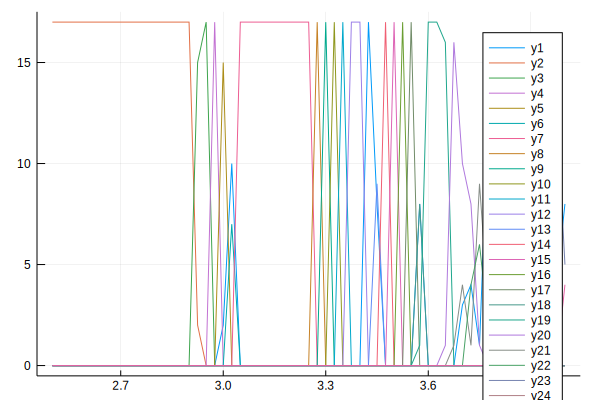

In [18]:
using Plots
plot(r,cluster_members)

# Example 3: Roessler Network

In [10]:
@everywhere N = 5

@everywhere k = 2
@everywhere p = 0.2
@everywhere net = watts_strogatz(N, k, p)

#@everywhere A = [0 1 1 
#    1 0 1 
#    1 1 0 ]
#@everywhere net = Graph(A)

@everywhere L = laplacian_matrix(net)

@everywhere a = ones(N).*0.2
@everywhere b = ones(N).*0.2
@everywhere c = ones(N).*7.0

tail_frac = 0.8

# for reference get the synchronizable range of Ks
evals = eig(full(L))[1]
evals = sort!(evals[evals .> 1e-5])
lambda_min = evals[end]
lambda_max = evals[1]
K_sync = (0.1232/lambda_min, 4.663/lambda_max)

(0.034051642517202586, 3.374178497908152)

In [11]:
#@everywhere K_range = [0.002, 0.004, 0.006, 0.008, 0.010, 0.03, 0.05, 0.1, 0.2, 0.5, 1, 2, 4]
@everywhere K_range = [0.002, 0.004, 0.03, 0.5, 1, 4]
#@everywhere K_range = [0.002, 0.005, 0.01, 0.025, 0.05, 0.07, 0.5, 1, 2]
#@everywhere K_range = [0.005, 0.007, 0.009, 0.011, 0.013, 0.016, 0.02, 0.03, 0.04, 0.9, 1.5, 2]
@everywhere ic_gen_xy = Uniform(-15.,15.)
@everywhere ic_gen_z = Uniform(-5.,20.)

@everywhere ic_gens = [()->rand(ic_gen_xy), ()-> rand(ic_gen_xy), ()->rand(ic_gen_z)]
@everywhere N_ic = 5


@everywhere rp = ODEProblem(roessler_network, zeros(3*N), (0.,100.), roessler_parameters(a,b,c,0.05,L,N))
@everywhere (ic_coupling_problem, ic_par, N_mc) = setup_ic_par_mc_problem(rp, ic_gens, N_ic, roessler_parameters(a,b,c,0.05,L,N),(:K,K_range))


In [5]:
rn_mcp = MonteCarloProblem(rp, prob_func=ic_coupling_problem, output_func=eval_ode_run_inf)
rn_emcp = EqMCProblem(rn_mcp, N_mc, tail_frac)
@time rn_sol = solve(rn_emcp)

@save "mc_roes_sol.jld2" rn_sol ic_par rn_emcp

if isdefined(:cluster)
    @save "mc_roes_sol.jld2" rn_sol ic_par rn_emcp
end 

  5.997917 seconds (35.68 M allocations: 865.371 MiB, 3.45% gc time)


In [2]:
@load "mc_roes_sol.jld2" rn_sol ic_par rn_empc
#@load "mc_roes_ic_par_inf.jld2" ic_par

LoadError: [91mKeyError: key "rn_empc" not found[39m

In [ ]:
D = distance_matrix(rn_sol);
k = 4
fdist = k_dist(D,k);

In [ ]:
x = collect(1:rn_sol.N_mc)
Plots.plot(x[1:end],fdist[1:end])

In [ ]:
eps = 6e8
db_res = dbscan(D,eps,k)
cluster_meas = cluster_measures(rn_sol, db_res)

# Example 4: Lotka Volterra

High Dimensional (N>=4) Lotka Volterra system can exhibit all kinds of interessting dynamics. Maybe it makes sense to study them with these tools

First we study the 4-dim model: $\frac{dN_i}{dt} = b_iN_i\left(1-\sum_{j=1}^n a_{ij}N_j\right),\qquad 1\leq i\leq n$

The parameter configuration

$ a = \left[ \begin{array}{cccc}
        1 & 1.09 & 1.52 & 0\\
        0 & 1 & 0.44 & 1.36\\
        2.33 & 0 & 1 & 0.47\\
        1.21 & 0.51 & 0.35 & 1\\
        \end{array} \right] $
        
$ b = \left(1, 0.72, 1.53, 1.27\right)$

is known to exhibit chaos with a strange attractor. Lets scan around these parameters.

In [9]:
@everywhere N = 4

@everywhere a = [1 1.09 1.52 0
                 0 1 0.44 1.36
                 2.33 0 1 0.47
                 1.21 0.51 0.35 1
                ]
@everywhere b = [1, 0.72, 1.53, 1.27]

@everywhere a12 = 0.69:0.1:2.59
@everywhere var_a = [a for i=1:length(a12)]
for i=1:length(a12)
        var_a[i][1,2] = a12[i]
end 

tail_frac = 0.8
@everywhere ic_gen = Uniform(-0.99,0.99)

@everywhere ic_gens = [()->rand(ic_gen)]
@everywhere N_ic = 100

@everywhere lvp = ODEProblem(lotka_volterra, zeros(N), (0.,100.), lotka_volterra_parameters(a,b,N))
@everywhere (ic_a_problem, ic_par, N_mc) = setup_ic_par_mc_problem(lvp, ic_gens, N_ic, lotka_volterra_parameters(a,b,N),(:a,var_a))


LoadError: [91m[91m[91mUndefVarError: Uniform not defined[39m
eval(::Module, ::Any) at ./boot.jl:235
eval_ew_expr at ./distributed/macros.jl:116 [inlined]
(::Base.Distributed.##135#136{Base.Distributed.#eval_ew_expr,Tuple{Expr},Array{Any,1}})() at ./distributed/remotecall.jl:319
run_work_thunk(::Base.Distributed.##135#136{Base.Distributed.#eval_ew_expr,Tuple{Expr},Array{Any,1}}, ::Bool) at ./distributed/process_messages.jl:56
#remotecall_fetch#140(::Array{Any,1}, ::Function, ::Function, ::Base.Distributed.LocalProcess, ::Expr, ::Vararg{Expr,N} where N) at ./distributed/remotecall.jl:344
remotecall_fetch(::Function, ::Base.Distributed.LocalProcess, ::Expr, ::Vararg{Expr,N} where N) at ./distributed/remotecall.jl:344
#remotecall_fetch#144(::Array{Any,1}, ::Function, ::Function, ::Int64, ::Expr, ::Vararg{Expr,N} where N) at ./distributed/remotecall.jl:372
remotecall_fetch(::Function, ::Int64, ::Expr, ::Vararg{Expr,N} where N) at ./distributed/remotecall.jl:372
(::##85#87)() at ./distributed/macros.jl:102[39m
#remotecall_fetch#140(::Array{Any,1}, ::Function, ::Function, ::Base.Distributed.LocalProcess, ::Expr, ::Vararg{Expr,N} where N) at ./distributed/remotecall.jl:345
remotecall_fetch(::Function, ::Base.Distributed.LocalProcess, ::Expr, ::Vararg{Expr,N} where N) at ./distributed/remotecall.jl:344
#remotecall_fetch#144(::Array{Any,1}, ::Function, ::Function, ::Int64, ::Expr, ::Vararg{Expr,N} where N) at ./distributed/remotecall.jl:372
remotecall_fetch(::Function, ::Int64, ::Expr, ::Vararg{Expr,N} where N) at ./distributed/remotecall.jl:372
(::##85#87)() at ./distributed/macros.jl:102[39m

In [8]:
lvp_mcp = MonteCarloProblem(lvp, prob_func=ic_a_problem, output_func=eval_ode_run_repeat)
lvp_emcp = EqMCProblem(lvp_mcp, N_mc, tail_frac)
@time lvp_sol = solve(lvp_emcp)

if isdefined(:cluster)
    @save "mc_lv_sol.jld2" lvp_sol
    @save "mc_lv_ic_par.jld2" ic_par
end 

4×4 Array{Float64,2}:
 1.0   2.59  1.52  0.0 
 0.0   1.0   0.44  1.36
 2.33  0.0   1.0   0.47
 1.21  0.51  0.35  1.0 

# Example 5: Henon Map

In [ ]:
@everywhere a = 2.5:0.02:4
@everywhere pars = henon_parameters(1,1)
@everywhere ic_ranges = [0.1:0.005:0.9]
@everywhere hmp = DiscreteProblem(henon, ic_ranges[1][1], (0.,500.), pars)
@everywhere (ic_r_prob, ic_par, N_mc) = setup_ic_par_mc_problem(hmp, ic_ranges, pars, (:a, a))

hm_mcp = MonteCarloProblem(dp, prob_func=ic_r_prob, output_func=eval_ode_run)
tail_frac = 0.8
hm_emcp = EqMCProblem(hm_mcp, N_mc, tail_frac)
hm_sol = solve(hm_emcp)

if isdefined(:cluster)
    @save "mc_log.jld2" hm_sol
end 